### Dataset preparation    
- convert glacier vector to glacier image.


In [3]:
import glob
import numpy as np
import geopandas as gpd
import rasterio as rio 
from rasterio import features
import matplotlib.pyplot as plt
from utils.imgShow import imgShow


In [4]:
### get the secene and truth pairwise data
# paths_scene = sorted(glob.glob('data/dset/scene/*.tif'))
paths_truth = sorted(glob.glob('data/dset/truth/*.gpkg'))
paths_scene = [path.replace('.gpkg', '.tif').replace('truth','scene') for path in paths_truth]
paths_dem = [path.replace('.gpkg', '_Dem.tif').replace('truth','scene') for path in paths_truth]
print(len(paths_scene))
print(len(paths_dem))
print(len(paths_truth))


65
65
65


In [22]:
## check the scene images and the truth vector
id_dset = 57
scene_rio = rio.open(paths_scene[id_dset])
truth_vec_gpd = gpd.read_file(paths_truth[id_dset])
scene_extent = [scene_rio.bounds.left, scene_rio.bounds.right, scene_rio.bounds.bottom, scene_rio.bounds.top]
print(paths_scene[id_dset], paths_truth[id_dset])


data/dset/scene/s2_scene_06.tif data/dset/truth/s2_scene_06.gpkg


<Axes: >

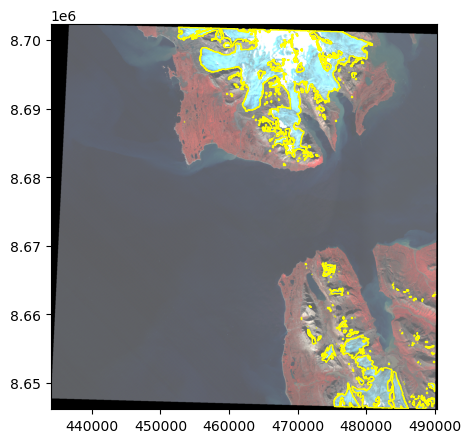

In [5]:
if scene_rio.crs != truth_vec_gpd.crs:
  print('crs transformation needed')
  truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
## show the scene and the truth vector
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
imgShow(scene_rio.read([2,3,4]).transpose(1,2,0), ax=ax,  extent=scene_extent)
truth_vec_gpd.plot(ax=ax, color='none', edgecolor='yellow', linewidth=1) 


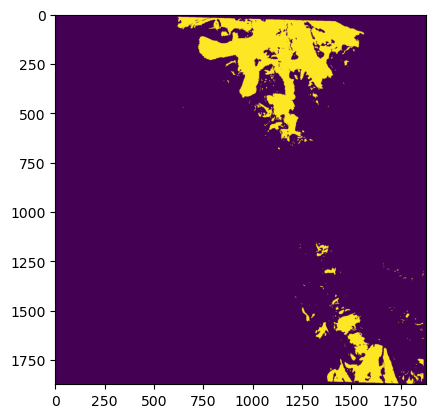

In [6]:
###  create a mask from the truth vector
def create_mask_from_vec(img_rio, vec_gpd):
    if vec_gpd.crs != img_rio.crs:
        vec_gpd = vec_gpd.to_crs(img_rio.crs.to_dict())
    shapes = [(geom, 1) for geom in vec_gpd.geometry if geom is not None and not geom.is_empty]

    mask_water = features.rasterize(
        shapes=shapes,
        out_shape=(img_rio.height, img_rio.width),
        transform=img_rio.transform,
        all_touched=False,
        default_value=1,
        fill=0,
        dtype=np.uint8)
    return mask_water

mask_water = create_mask_from_vec(img_rio = scene_rio, vec_gpd=truth_vec_gpd)
plt.imshow(mask_water) 


In [7]:
## write the mask to a geotiff
path_truth_gpkg = paths_truth[id_dset]
path_truth_img = path_truth_gpkg.replace('.gpkg', '.tif')

def write_mask_to_geotiff(mask, scene_rio, path_save):
    mask_meta = scene_rio.meta.copy()
    mask_meta.update({
        'dtype': 'uint8',
        'count': 1,
        'compress': 'lzw',
        'nodata': 0
    })
    
    with rio.open(path_save, 'w', **mask_meta) as dst:
        dst.write(mask, 1)
    print('mask written to', path_save)

write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, path_save = path_truth_img)


mask written to data/dset/truth/l5_scene_13.tif


In [8]:
## convert the .gpkg vector to .tiff truth image.
for i, path_truth_vec in enumerate(paths_truth):
    truth_vec_gpd = gpd.read_file(path_truth_vec)
    scene_rio = rio.open(paths_scene[i])
    ### generate water mask
    if scene_rio.crs != truth_vec_gpd.crs:
        truth_vec_gpd = truth_vec_gpd.to_crs(scene_rio.crs.to_dict())
    mask_water = create_mask_from_vec(img_rio = scene_rio, 
                                        vec_gpd=truth_vec_gpd)
    ### write the water mask to a geotiff
    path_truth_img = path_truth_vec.replace('.gpkg', '.tif')
    write_mask_to_geotiff(mask = mask_water, scene_rio=scene_rio, 
                                        path_save = path_truth_img)
    scene_rio.close()


mask written to data/dset/truth/l5_scene_01.tif
mask written to data/dset/truth/l5_scene_02.tif
mask written to data/dset/truth/l5_scene_03.tif
mask written to data/dset/truth/l5_scene_04.tif
mask written to data/dset/truth/l5_scene_05.tif
mask written to data/dset/truth/l5_scene_06.tif
mask written to data/dset/truth/l5_scene_07.tif
mask written to data/dset/truth/l5_scene_08.tif
mask written to data/dset/truth/l5_scene_09.tif
mask written to data/dset/truth/l5_scene_10.tif
mask written to data/dset/truth/l5_scene_11.tif
mask written to data/dset/truth/l5_scene_12.tif
mask written to data/dset/truth/l5_scene_13.tif
mask written to data/dset/truth/l7_scene_01.tif
mask written to data/dset/truth/l7_scene_02.tif
mask written to data/dset/truth/l7_scene_03.tif
mask written to data/dset/truth/l7_scene_04.tif
mask written to data/dset/truth/l7_scene_05.tif
mask written to data/dset/truth/l7_scene_06.tif
mask written to data/dset/truth/l7_scene_07.tif
mask written to data/dset/truth/l7_scene